In [1]:
import numpy as np
import torch
# random seed
np.random.seed(42)
torch.manual_seed(42)

## Data Set and Optimization Solver

In [2]:
import time

from gurobipy import GRB
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

from pyepo.model.opt import optModel


class optDatasetConstrs(Dataset):
    """
    This class is Torch Dataset for optimization problems with active constraints.

    Attributes:
        model (optModel): Optimization models
        feats (np.ndarray): Data features
        costs (np.ndarray): Cost vectors
        sols (np.ndarray): Optimal solutions
        ctrs (list(np.ndarray)): active constraints
    """

    def __init__(self, model, feats, costs=None, sols=None):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): an instance of optModel
            feats (np.ndarray): data features
            costs (np.ndarray): costs of objective function
            sols (np.ndarray): optimal solutions
        """
        if not isinstance(model, optModel):
            raise TypeError("arg model is not an optModel")
        if (costs is None) and (sols is None):
            raise ValueError("At least one of 'costs' or 'sols' must be provided.")
        self.model = model
        # data
        self.feats = feats
        # find optimal solutions and tight constraints
        if sols is None:
            self.costs = costs
            self.sols, self.ctrs = self._getSols()
        # get tight constraints
        else:
            self.costs = None
            self.sols = sols
            self.ctrs = self._getCtrs()

    def _getSols(self):
        """
        A method to get optimal solutions for all cost vectors
        """
        sols, ctrs = [], []
        print("Optimizing for optDataset...")
        time.sleep(1)
        for c in tqdm(self.costs):
            try:
                # solve
                sol = self._solve(c)
                # get constrs
                constrs = self._getBindingConstrs(self.model._model)
            except:
                raise ValueError(
                    "For optModel, the method 'solve' should return solution vector and objective value."
                )
            sols.append(sol)
            ctrs.append(np.array(constrs))
        return np.array(sols), ctrs
    
    def _getCtrs(self):
        """
        A method to get the binding constraints from given solution
        """
        ctrs = []
        print("Obtaining constraints for optDataset...")
        time.sleep(1)
        for sol in tqdm(self.sols):
            # give sol
            model = self._assignSol(sol)
            # get constrs
            constrs = self._getBindingConstrs(model)
            ctrs.append(np.array(constrs))
        return ctrs

    def _solve(self, cost):
        """
        A method to solve optimization problem to get an optimal solution with given cost

        Args:
            cost (np.ndarray): cost of objective function

        Returns:
            tuple: optimal solution (np.ndarray) and objective value (float)
        """
        self.model.setObj(cost)
        sol, _ = self.model.solve()
        return sol
    
    def _assignSol(self, sol):
        """
        A method to fix model with given solution 

        Args:
            sols (np.ndarray): Optimal solutions

        Returns:
            model (optModel): Optimization models
        """
        # copy model
        model = self.model.copy()
        # fix value
        for i, k in enumerate(self.model.x):
            model.x[k].lb = sol[i]
            model.x[k].ub = sol[i]
        # set 0 obj
        model._model.setObjective(0)
        # solve
        model._model.optimize()
        return model._model
        

    def _getBindingConstrs(self, model):
        """
        A method to get tight constraints with current solution
        
        Args:
            model (optModel): Optimization models

        Returns:
            np.ndarray: normal vector of constraints
        """
        xs = model.getVars()
        constrs = []
        # iterate all constraints
        for constr in model.getConstrs():
            # check tight constraints
            if abs(constr.Slack) < 1e-5:
                t_constr = []
                # get coefficients
                for x in xs:
                    t_constr.append(model.getCoeff(constr, x))
                # get coefficients in standard form
                if constr.sense == GRB.LESS_EQUAL:
                    # <=
                    constrs.append(t_constr)
                elif constr.sense == GRB.GREATER_EQUAL:
                    # >=
                    constrs.append([- coef for coef in t_constr])
                elif constr.sense == GRB.EQUAL:
                    # ==
                    constrs.append(t_constr)
                    constrs.append([- coef for coef in t_constr])
                else:
                    # invalid sense
                    raise ValueError("Invalid constraint sense.")
        # iterate all variables
        for i, x in enumerate(xs):
            t_constr = [0] * len(xs)
            # add bounds as cosnrtaints
            if x.x <= 1e-5:
                # x_i >= 0
                t_constr[i] = - 1
                constrs.append(t_constr)
            elif x.x >= 1 - 1e-5:
                # x_i <= 1
                t_constr[i] = 1
                constrs.append(t_constr)
        return constrs

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.feats)

    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        if self.costs is None:
            return (
                torch.FloatTensor(self.feats[index]),
                torch.FloatTensor(self.sols[index]),
                torch.FloatTensor(self.ctrs[index])
            )
        else:
            return (
                torch.FloatTensor(self.feats[index]),
                torch.FloatTensor(self.costs[index]),
                torch.FloatTensor(self.sols[index]),
                torch.FloatTensor(self.ctrs[index])
            )

Auto-Sklearn cannot be imported.


In [3]:
import pyepo

In [4]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0 #0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

In [5]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Restricted license - for non-production use only - expires 2024-10-28
Obj: 4.5703345390527765
(0, 5)
(5, 6)
(6, 11)
(11, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [6]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
# get training and test data set
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 633.93it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1246.93it/s]


In [7]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train.sols) # with binding constr

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1051.01it/s]


In [8]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [9]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

In [10]:
# init model
reg = LinearRegression()

## Loss

In [11]:
from torch.autograd import Function
import gurobipy as gp
from gurobipy import GRB

from pyepo import EPO

In [12]:
from torch.autograd import Function
from torch.nn import functional as F
from pyepo import EPO

class polarConeAngle(nn.Module):
    """
    A autograd module for polar cone fitting loss with binary variables
    """

    def __init__(self, optmodel):
        """
        Args:
            optmodel (optModel): an PyEPO optimization model
        """
        super().__init__()
        # optimization model
        if not isinstance(optmodel, optModel):
            raise TypeError("arg model is not an optModel")
        self.optmodel = optmodel

    def forward(self, pred_cost, tight_ctrs, reduction="mean"):
        """
        Forward pass
        """
        loss = self._calLoss(pred_cost, tight_ctrs, self.optmodel)
        # reduction
        if reduction == "mean":
            loss = torch.mean(loss)
        elif reduction == "sum":
            loss = torch.sum(loss)
        elif reduction == "none":
            loss = loss
        else:
            raise ValueError("No reduction '{}'.".format(reduction))
        return loss

    def _calLoss(self, pred_cost, tight_ctrs, optmodel):
        """
        A method to calculate loss
        """
        # get device
        device = pred_cost.device
        # get batch size
        batch_size = len(pred_cost)
        # init loss
        loss = torch.empty(batch_size).to(device)
        # cost vectors direction
        if optmodel.modelSense == EPO.MINIMIZE:
            # minimize
            pred_cost = - pred_cost
        # constraints to numpy
        tight_ctrs = tight_ctrs.cpu().detach().numpy()
        for i in range(batch_size):
            # get projection
            p = self._getProjection(pred_cost[i], tight_ctrs[i])
            # calculate cosine similarity
            loss[i] = - F.cosine_similarity(pred_cost[i].unsqueeze(0), p.unsqueeze(0))
        return loss

    def _getProjection(self, cp, ctr):
        """
        A method to get the projection of the vector onto the polar cone via solving a quadratic programming
        """
        # ceate a model
        m = gp.Model("projection")
        # turn off output
        m.Params.outputFlag = 0
        # varibles
        p = m.addVars(len(cp), name="x", lb=-GRB.INFINITY)
        λ = m.addVars(len(ctr), name="lambda")
        # onjective function
        obj = gp.quicksum((cp[i].item() - p[i]) ** 2 for i in range(len(cp)))
        m.setObjective(obj, GRB.MINIMIZE)
        # constraints
        for i in range(len(cp)):
            m.addConstr(gp.quicksum(ctr[j,i] * λ[j] for j in range(len(ctr))) == p[i])
        # focus on numeric problem
        m.Params.NumericFocus = 3
        # solve
        m.update()
        m.optimize()
        # get solutions
        λ_val = np.array([λ[i].x for i in λ])
        # normalize
        λ_norm = λ_val / np.linalg.norm(λ_val)
        # get normalized projection
        proj = torch.FloatTensor(λ_norm @ ctr)
        return proj

In [13]:
# init loss
pca_loss = polarConeAngle(optmodel)

## Train

In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=5e-3)

In [15]:
num_epochs = 20
log_step = 2
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pca_loss(cp, t_ctr)
        #loss = torch.sum(cp)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret)
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
        # print gradients
        #for name, param in reg.named_parameters():
        #    if param.requires_grad:
        #        print(f"Gradient of {name}: {param.grad}")
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  -0.9972, Regret: 28.5068%
Epoch   2, Loss:  -0.9966, Regret: 12.2269%
Epoch   4, Loss:  -0.9999, Regret:  6.2399%
Epoch   6, Loss:  -1.0000, Regret:  3.7113%
Epoch   8, Loss:  -1.0000, Regret:  3.0097%
Epoch  10, Loss:  -1.0000, Regret:  2.6737%
Epoch  12, Loss:  -0.9999, Regret:  2.5079%
Epoch  14, Loss:  -1.0000, Regret:  1.8953%
Epoch  16, Loss:  -1.0000, Regret:  1.8329%
Epoch  18, Loss:  -1.0000, Regret:  1.5127%
Elapsed Time: 1215.62 Sec


In [16]:
from matplotlib import pyplot as plt

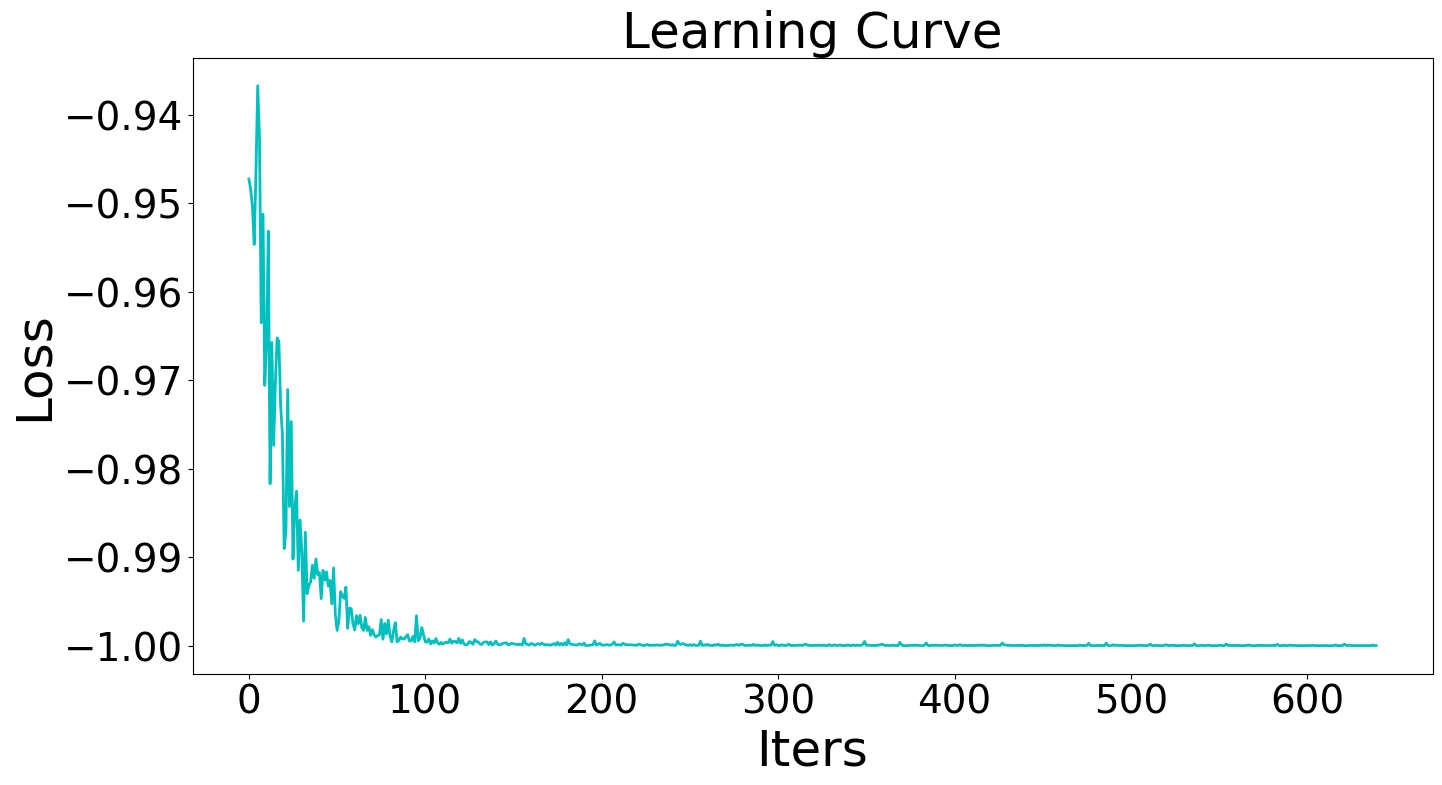

In [17]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Iters", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

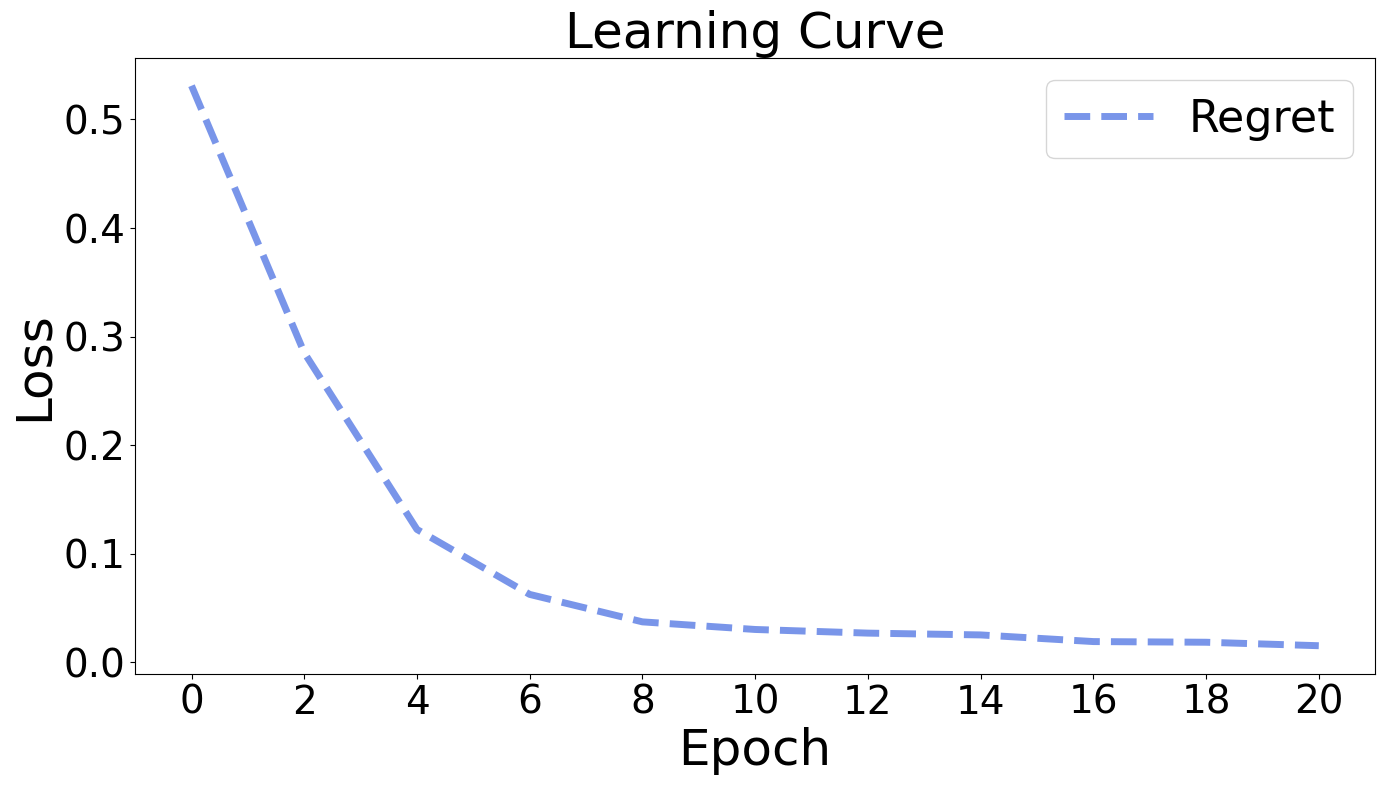

In [18]:
# draw plot
fig = plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
plt.xticks(range(0, num_epochs+1, log_step), fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()